# Qiskit Lab2

In [2]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import math
from qiskit.circuit.library import QFT

In [3]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

### 1.Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'. Execute 'qc4' on a qasm simulator. Plot the histogram of the result.

In [4]:
## Start your code to create the circuit
qc4=QuantumCircuit(5, 4)
for qubit in range(4):
    qc4.h(qubit)

qc4.x(4)

# Do the controlled-U operations, here the Unitary to do QFFT is rotation(2pi/3)
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(4):
    for i in range(repetitions):
        qc4.cp(angle, counting_qubit, 4);
    repetitions *= 2

# Do the inverse QFT:
qc4 = qc4.compose(QFT(4, inverse=True), [0,1,2,3])

# Measure of course
for n in range(4):
    qc4.measure(n,n)

qc4.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_4: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 4/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_4: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 4/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                         ┌──────────┐┌─┐         
«q_0: ────────────────────┤0         ├┤M├─────────
«                         │          │└╥┘┌─┐      
«q_1: ────────────────────┤1         ├─╫─┤M├──────
«                         │  IQFT_dg │ ║ └╥┘┌─┐   
«q_2: ────────────────────┤2         ├─╫──╫─┤M├───
«                         │          │ ║  ║ └╥┘┌─┐
«q_3: ─■─────────■────────┤3         ├─╫──╫──╫─┤M├
«      │P(2π/3)  │P(2π/3) └──────────┘ ║  ║  ║ └╥┘
«q_4: ─■─────────■─────────────────────╫──╫──╫──╫─
«                                      ║  ║  ║  ║ 
«c: 4/═════════════════════════════════╩══╩══╩══╩═
«                                      0  1  2  3

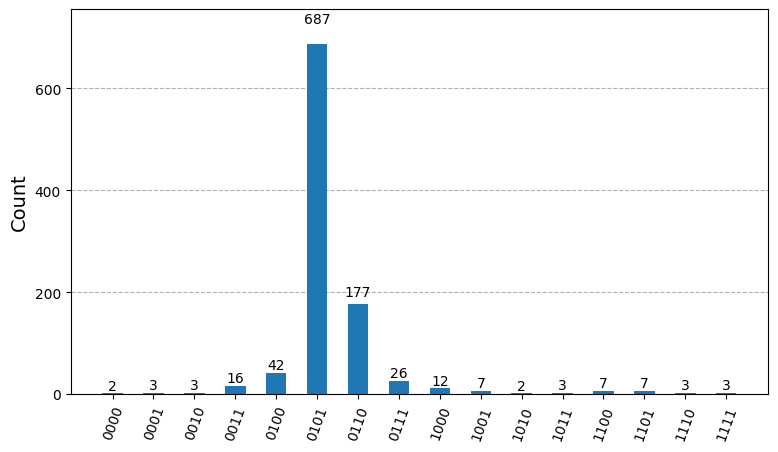

In [5]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = AerSimulator()
shots = 20000
transpiled_circuit = transpile(qc4, sim)
job = sim.run(transpiled_circuit, shots=1000) # Run the circuit 1000 times 
count_qc4 = job.result().get_counts() 



plot_histogram(count_qc4, figsize=(9,5))

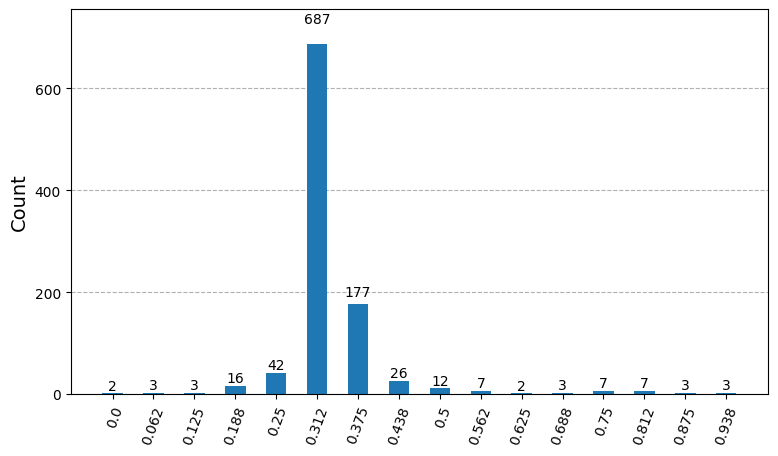

In [8]:
t=4
phi_est = np.array([round(int(key, 2)/2**t,3) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

### Step B. Find e

In [10]:
e=0
t=4
b=0.3125
phi=1/3
check=True
while check:
   e+=1
   #Enumerate all possible m by binary form
   for m in range(0,16):
       #Check for all feasible m
        if abs(m/16-b)<=e/(2**t):
            if not (m/16-phi)/phi<=(1/4):
                e-=1
                check=False
                break
   if check:
       print(f"The maximum difference is e={e}")

The maximum difference is e=1


### Step C: Compute the probability

In [11]:
sum=0
count=0
for key in count_new.keys():
    sum+=count_new[key]
    value=float(key)
    if abs(value-phi)/phi<2**(-2):
        count+=count_new[key]
probability=count/sum
print(f"The probability of obtaining an approximation correct to an accuracy 1/4 is {probability}")

The probability of obtaining an approximation correct to an accuracy 1/4 is 0.906


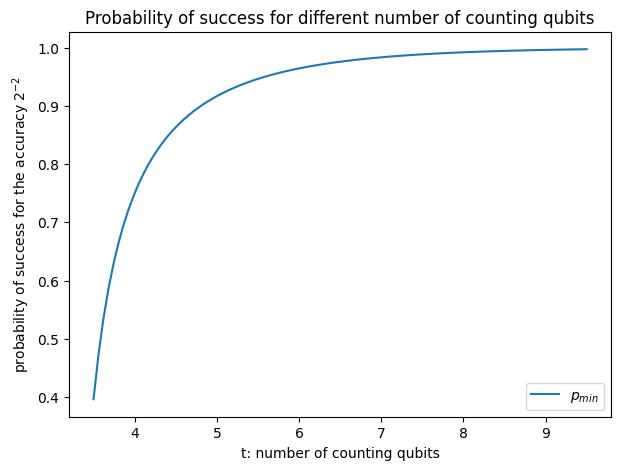

In [21]:
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

In [12]:
## Return the counted result for QFT with n count qubit
def QFE(n):
    qcn=QuantumCircuit(n+1, n)
    for qubit in range(n):
        qcn.h(qubit)
    
    qcn.x(n)
    
    # Do the controlled-U operations:
    angle = 2*math.pi/3
    repetitions = 1
    for counting_qubit in range(n):
        for i in range(repetitions):
            qcn.cp(angle, counting_qubit, n);
        repetitions *= 2
    
    # Do the inverse QFT:
    qcn = qcn.compose(QFT(n, inverse=True), list(range(n)))
    
    # Measure of course!
    for k in range(n):
        qcn.measure(k,k)

    sim = AerSimulator()
    shots = 20000
    transpiled_circuit = transpile(qcn, sim)
    job = sim.run(transpiled_circuit, shots=shots) # Run the circuit 1000 times 
    count_qcn = job.result().get_counts() 
    

    t=n
    phi_est = np.array([round(int(key, 2)/2**t,n) for key in list(count_qcn.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count_qcn.values()))    
    return count_new


In [13]:
# Return the QFE circuit with n count qubits
def QFE_circuit(n):
    qcn=QuantumCircuit(n+1, n)
    for qubit in range(n):
        qcn.h(qubit)
    
    qcn.x(n)
    
    # Do the controlled-U operations:
    angle = 2*math.pi/3
    repetitions = 1
    for counting_qubit in range(n):
        for i in range(repetitions):
            qcn.cp(angle, counting_qubit, n);
        repetitions *= 2
    
    # Do the inverse QFT:
    qcn = qcn.compose(QFT(n, inverse=True), list(range(n)))
    
    # Measure of course!
    for k in range(n):
        qcn.measure(k,k)
    return qcn

### Step A. Construct QPE circuit to estimate phi when phi=1/3 with for the different number of counting qubits t , when t=[4,5,6,7,8,9]. Store all the circuits in a list variable 'circ' to simulate all the circuits at once as we did in Lab3.

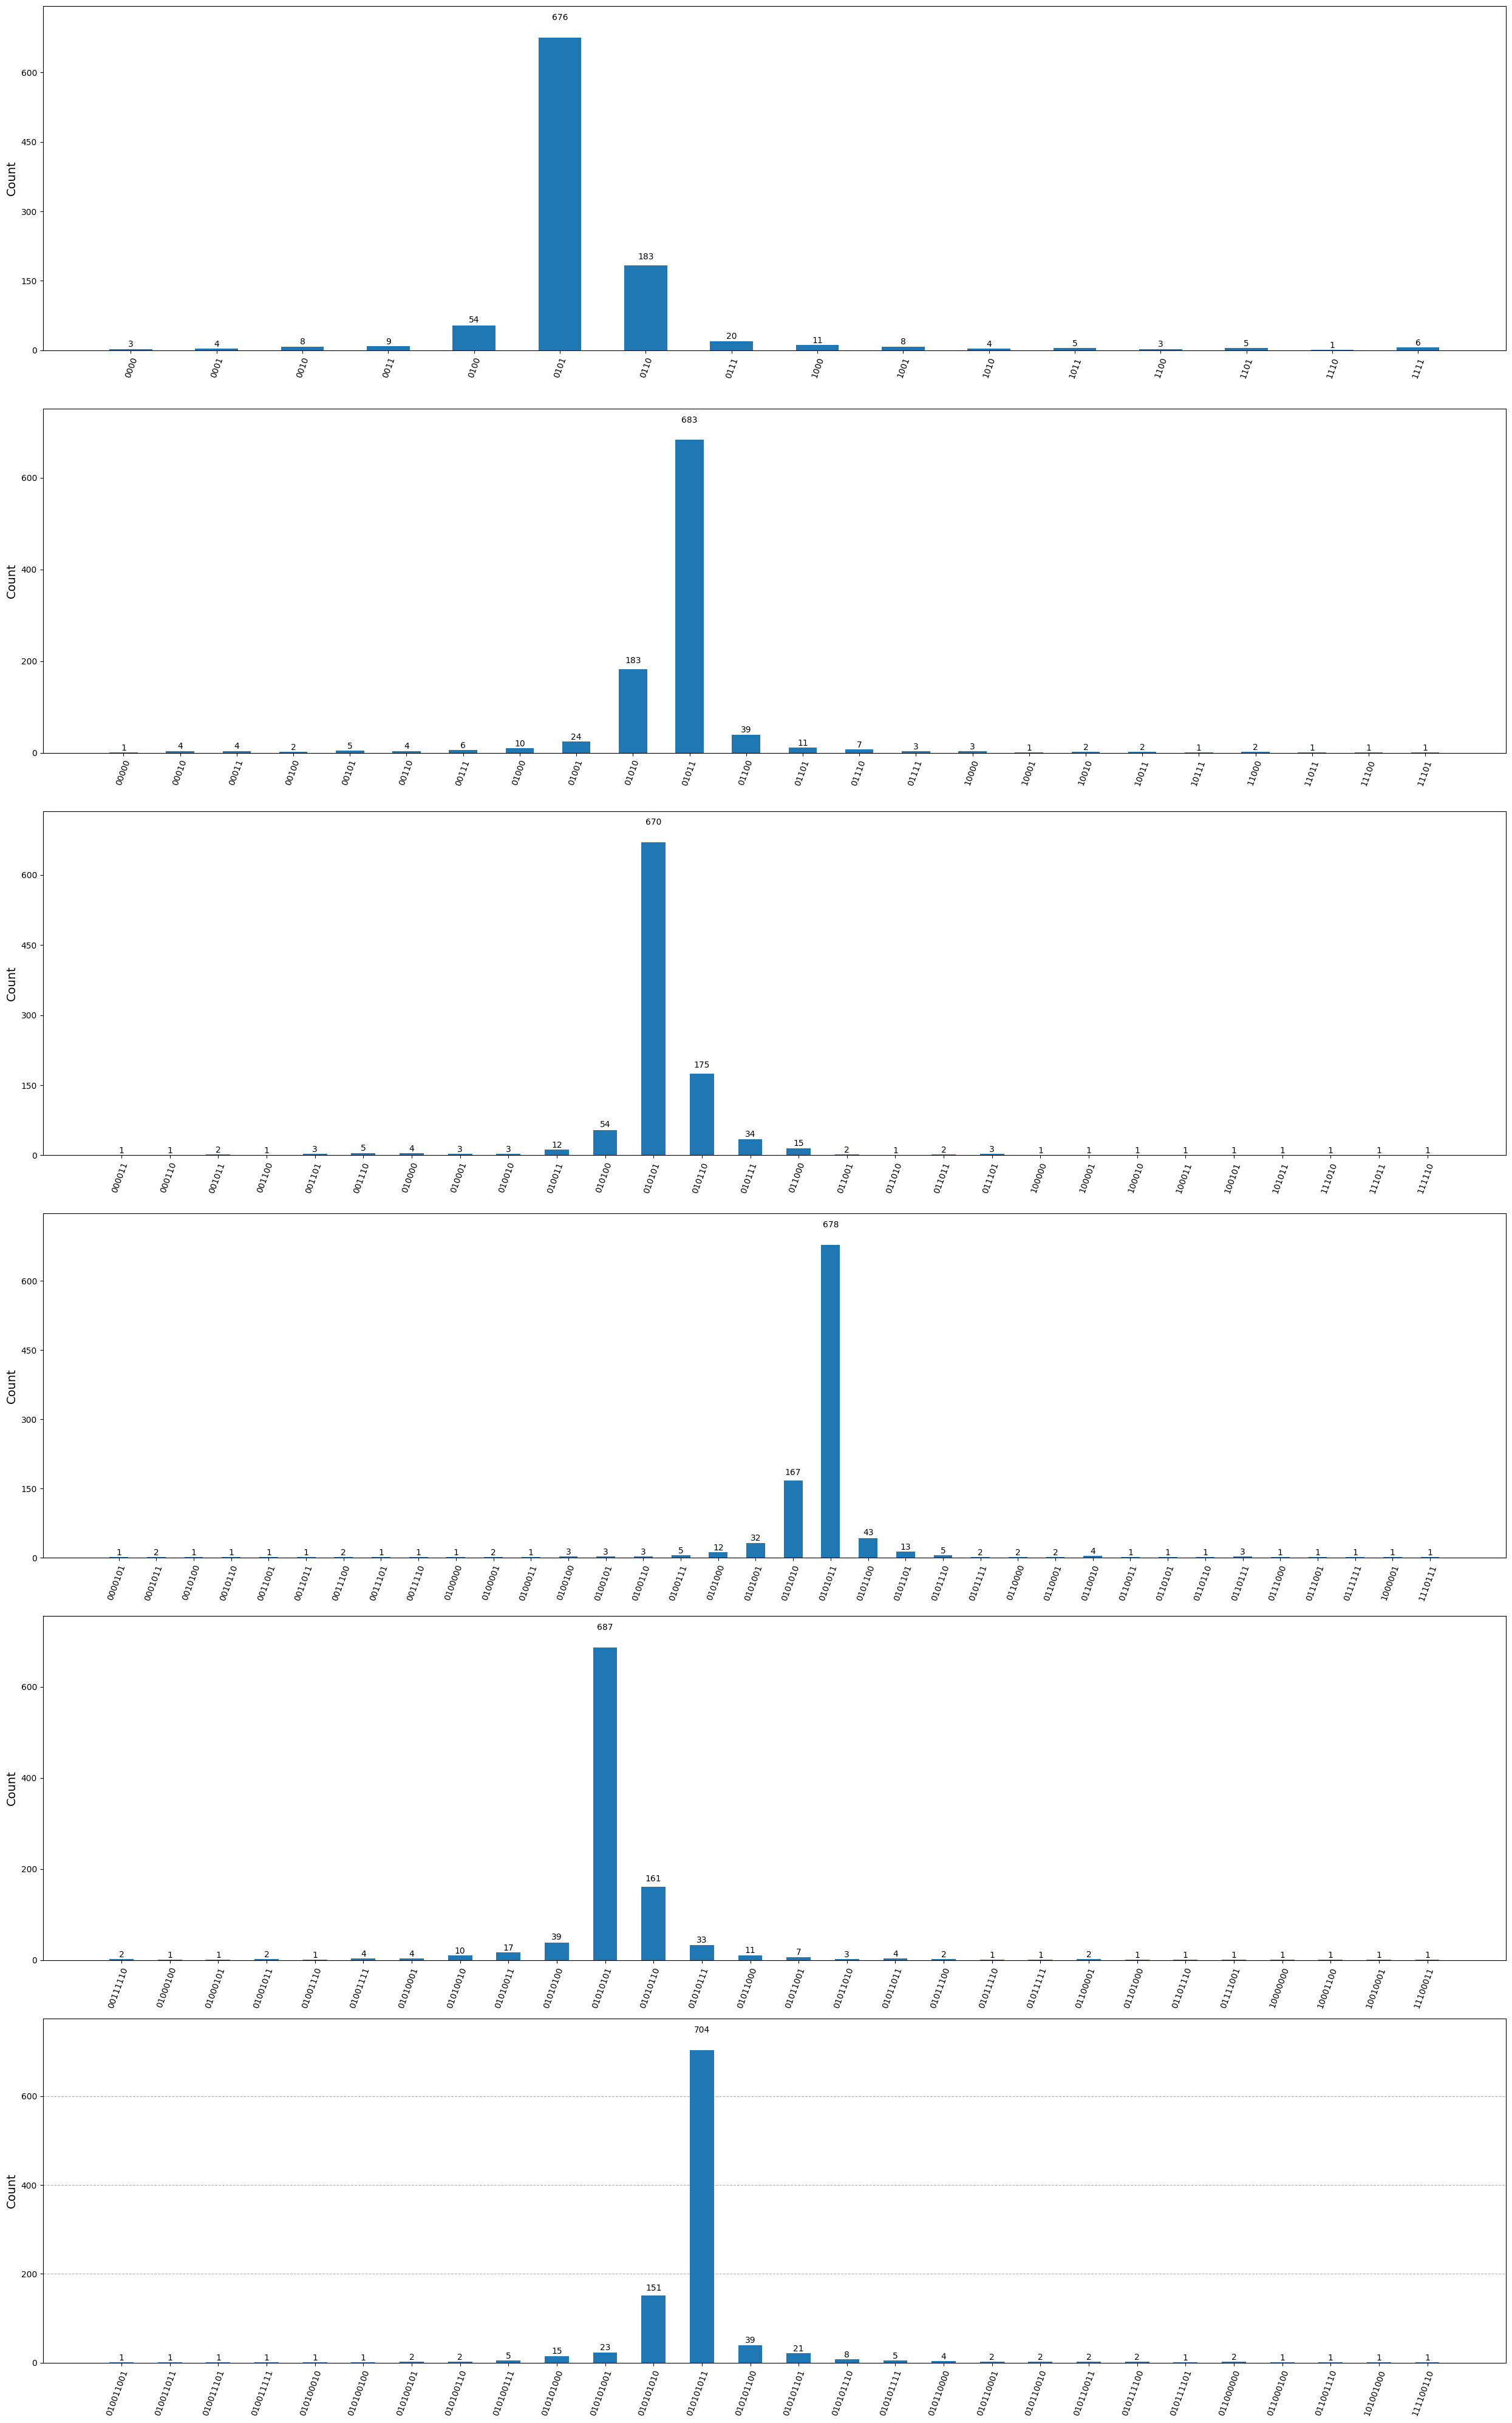

In [14]:
circ=[]
t_list=[4,5,6,7,8,9]
for t in t_list:
    circ.append(QFE_circuit(t))
# Run this cell to simulate `circ` and plot the histograms of the results



sim = AerSimulator()
shots = 20000
transpiled_circuit = transpile(circ, sim)
job = sim.run(transpiled_circuit, shots=1000) # Run the circuit 1000 times 
results = job.result()



n_circ = len(circ)
counts = [results.get_counts(idx) for idx in range(n_circ)]

fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts[idx], ax=ax[idx])
plt.tight_layout()

### Determine e , the maximum difference in integer from the best estimation for the different numer of counting qubits 

In [15]:
#The list for b
max_value_list=[]
n=4
for count_result in counts:
    max_key=max(count_result,key=count_result.get)
    b=int(max_key,2)/(2**n)
    n+=1
    max_value_list.append(b)

Text(0, 0.5, 'The maximum distance from the best estimate for 2^-2')

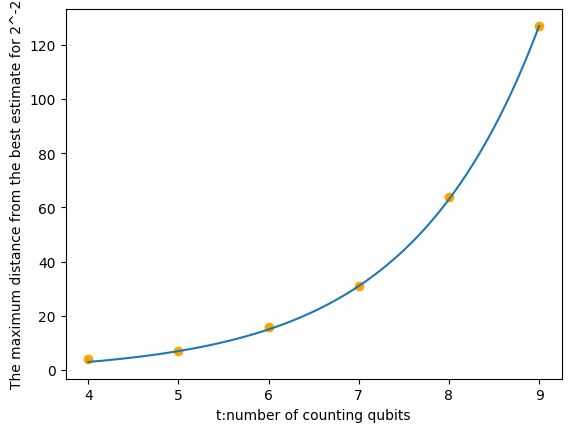

In [16]:
e_list=[]
for i in range(len(t_list)):
    e=0
    b=max_value_list[i]
    t=t_list[i]
    phi=1/3
    check=True
    while check:
       e+=1
       #Enumerate all possible m by binary form
       for m in range(0,2**t):
           #Check for all feasible m in binary fomat
           #Here, m/m**t is the actual value of phase the we estimate, for example,
           # when t=3, m=101=5, the value is 0.101=5/8
            if abs(m/2**t-b)<=e/(2**t):
                if not (m/2**t-phi)<=(1/4):
                    e-=1
                    check=False
                    break
    e_list.append(e)
t_fit_list=np.linspace(4,9,100)
fit_list=[2**(t-2)-1 for t in t_fit_list]
t_list=[4,5,6,7,8,9]
plt.plot(t_fit_list,fit_list)
plt.scatter(t_list,e_list,color='orange')
plt.xlabel('t:number of counting qubits')
plt.ylabel('The maximum distance from the best estimate for 2^-2')

### valuate the probability of success

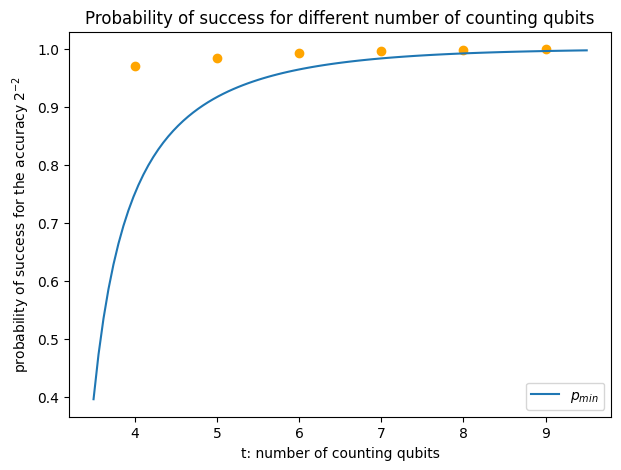

In [17]:
t_list=[4,5,6,7,8,9]
prob_success=[]

for t in t_list:
    sum=0
    count=0
    count_new=QFE(t)
    for key in count_new.keys():
        sum+=count_new[key]
        value=float(key)
        if abs(value-phi)<=2**(-2):
            count+=count_new[key]
    probability=count/sum
    prob_success.append(probability)



y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.scatter(t_list,prob_success,color='orange')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()


### Part2. Use noisy fake quantum computer and redo the above experiment